In [122]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pyrenn
sns.set(style='ticks')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.interpolate import griddata
from scipy.stats import spearmanr
from matplotlib.pyplot import figure
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error

from pickle import load

import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par

In [123]:
#Read ANN data and model                                                                                        
activation_function='tanh';train_size=60
sigma=0.04; realization=2                                           
file_data='NN_tanh_sigma_' + str(sigma) + '_r_' + str(realization) + '.csv'
d='../data/' + file_data
d=pd.read_csv(d)

n=7
dn=d[d['rep']==n]
dn=dn[(dn['x1']>=-2.0) & (dn['x1']<=2.0)]
dn.set_index('Unnamed: 0', inplace=True)
dn.index.name = None
dn=dn.reset_index(drop=True)

print(dn)

      x1         y  rep     noise   y_noise
0  -1.95  0.000742  7.0  0.025489  0.026230
1  -1.90  0.000555  7.0 -0.034723 -0.034169
2  -1.85  0.000384  7.0 -0.016451 -0.016067
3  -1.80  0.000236  7.0 -0.024604 -0.024368
4  -1.75  0.000117  7.0  0.038539  0.038655
..   ...       ...  ...       ...       ...
75  1.80  0.128330  7.0  0.031789  0.160118
76  1.85  0.132584  7.0  0.008559  0.141143
77  1.90  0.137246  7.0 -0.008202  0.129044
78  1.95  0.142347  7.0  0.064814  0.207161
79  2.00  0.147925  7.0 -0.104051  0.043873

[80 rows x 5 columns]


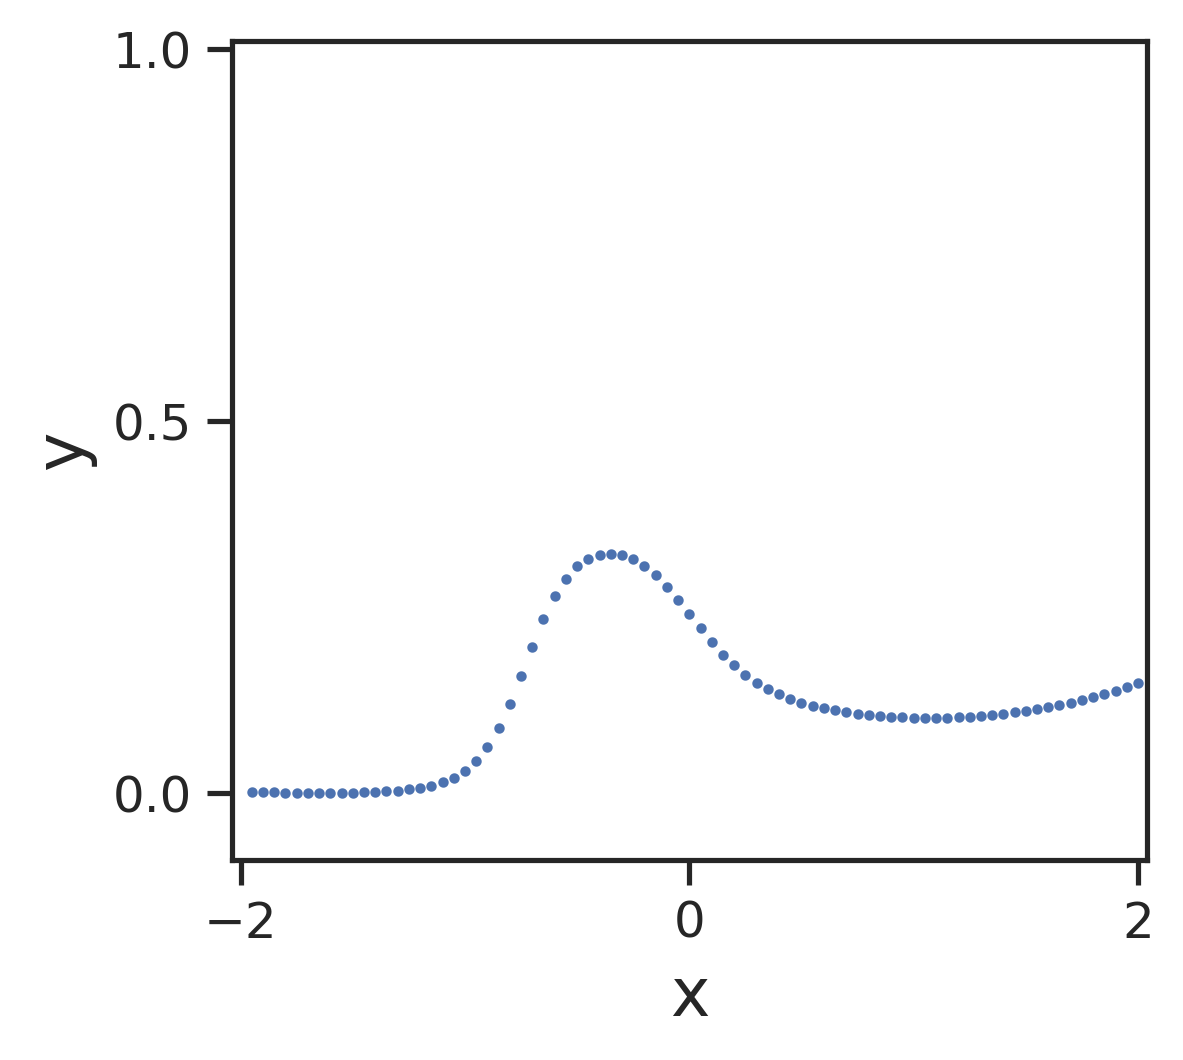

In [124]:
#Figure settings
output_path='../results/tutorial/' #A path to save figure
extensions=['.svg', '.png']     #Extensions to save figure
#Define figure size in cm
cm = 1/2.54 #convert inch to cm
width = 10*cm; height=9*cm 
fig=figure(figsize=(width,height), dpi=300) 
#Fonts and sizes                                                     
size_axis=16;size_ticks=12;size_title=5
line_w=1.5;marker_s=3
#figure parameters
xtick_labels=[-2, 0, 2 ]
ytick_labels=[ 0, 0.5, 1.0]
xmin=-2.04;xmax=2.04
ymin=-0.09;ymax=1.01
#--------------------------------

#Plots                                                               
#--------------------------------                                    
plt.plot(dn.x1,dn.y,'.', markersize=marker_s)

#Labels                                                              
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
#Ticks                                                               
plt.xticks(xtick_labels, fontsize=size_ticks)
plt.yticks(ytick_labels, fontsize=size_ticks)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

#save fig  
name_fig='observed_data'
for ext in extensions:
    plt.savefig(output_path+name_fig+ext,dpi=300)

plt.show()
#-------------------------------- 


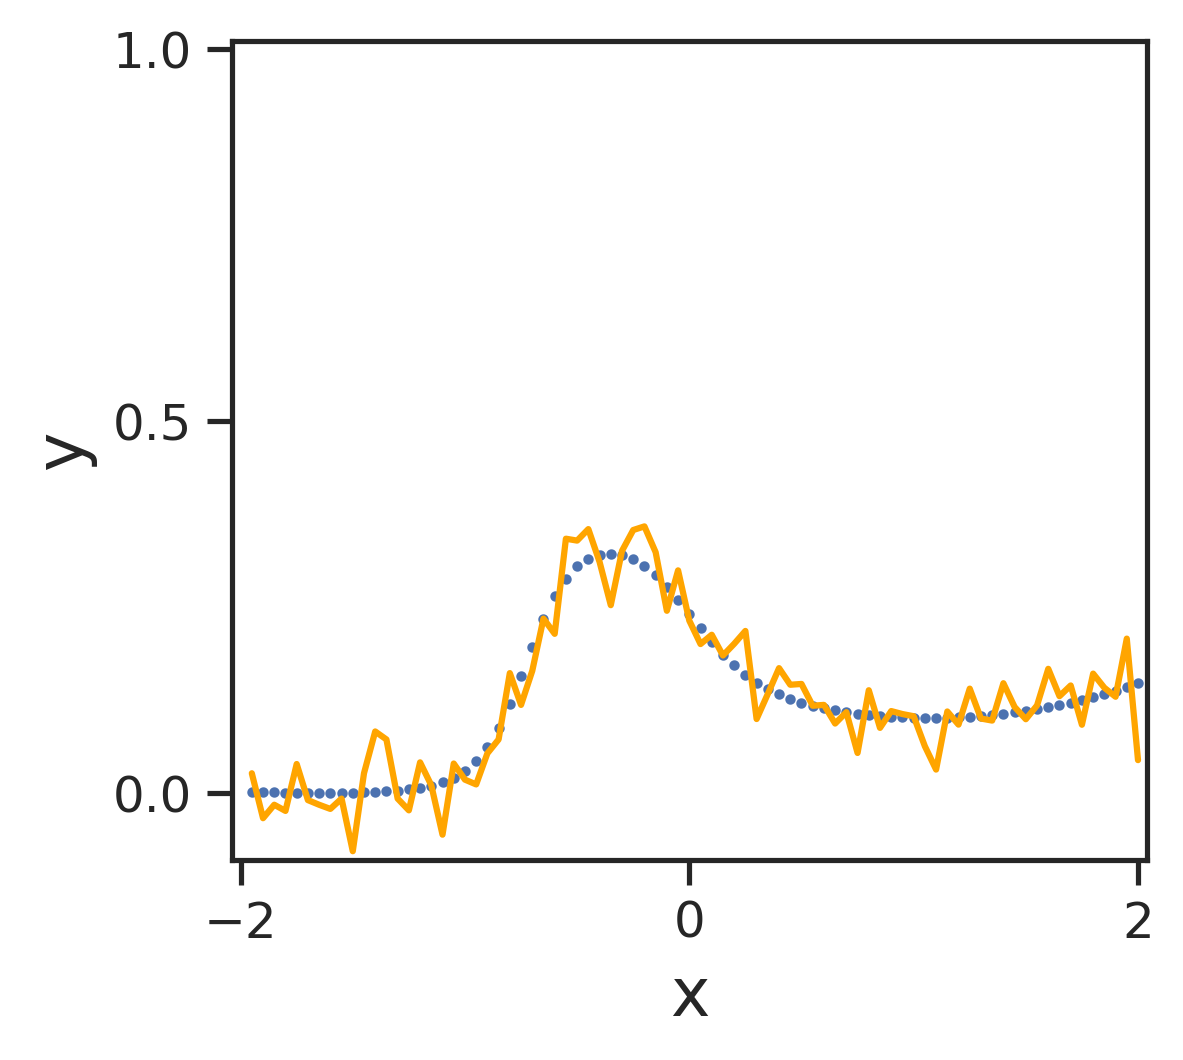

In [125]:
#Define figure
fig=figure(figsize=(width,height), dpi=300) 

#Plots                                                               
#--------------------------------                                    
plt.plot(dn.x1,dn.y,'.', markersize=marker_s)
plt.plot(dn.x1,dn.y_noise,linewidth=line_w,color='orange') #gaussian nosie

#Labels                                                              
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
#Ticks                                                               
plt.xticks(xtick_labels, fontsize=size_ticks)
plt.yticks(ytick_labels, fontsize=size_ticks)
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)

#save fig  
name_fig='noise'
for ext in extensions:
    plt.savefig(output_path+name_fig+ext,dpi=300)

plt.show()
#-------------------------------- 

In [126]:
#Read NN and BMS data
NPAR=10 #10, 20
steps=50000

#Read NN data
train_size=60
file_model='NN_no_overfit_' + activation_function + '_sigma_' + str(sigma) + '_r_' + str(realization) + '.csv'

model_d='../data/trained_nns/' + file_model
d=pd.read_csv(model_d)
dn=d[d['rep']==n]
dn.set_index('Unnamed: 0', inplace=True)
dn.index.name = None
dn=dn.reset_index(drop=True)
display(dn)

#Read BMS trace
filename='BMS_'+activation_function+'_n_'+str(n)+'_sigma_'+str(sigma)+ '_r_' + str(realization) + \
'_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'
trace=pd.read_csv('../data/MSTraces/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])

,x1,y,rep,noise,y_noise,ymodel
0,-1.95,0.000742,7.0,0.025489,0.026230,0.014360
1,-1.90,0.000555,7.0,-0.034723,-0.034169,0.009264
2,-1.85,0.000384,7.0,-0.016451,-0.016067,0.004457
3,-1.80,0.000236,7.0,-0.024604,-0.024368,-0.000004
4,-1.75,0.000117,7.0,0.038539,0.038655,-0.004054
...,...,...,...,...,...,...
75,1.80,0.128330,7.0,0.031789,0.160118,0.401244
76,1.85,0.132584,7.0,0.008559,0.141143,0.405925
77,1.90,0.137246,7.0,-0.008202,0.129044,0.410341
78,1.95,0.142347,7.0,0.064814,0.207161,0.414512


In [127]:
#Parameters to read models
VARS = ['x1',]
x = dn[[c for c in VARS]].copy()
y=dn.noise

if NPAR==10:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np10.2017-10-18 18:07:35.089658.dat')
elif NPAR==20:
    prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np20.maxs200.2024-05-10 162907.551306.dat')

#Minimum description length model
minrow = trace[trace.H == min(trace.H)].iloc[0]
minH, minexpr, minparvals = minrow.H, minrow.expr, ast.literal_eval(minrow.parvals)

t = Tree(
    variables=list(x.columns),
    parameters=['a%d' % i for i in range(NPAR)],
    x=x, y=y,
    prior_par=prior_par,
    max_size=200,
    from_string=minexpr,
)

t.set_par_values(deepcopy(minparvals))

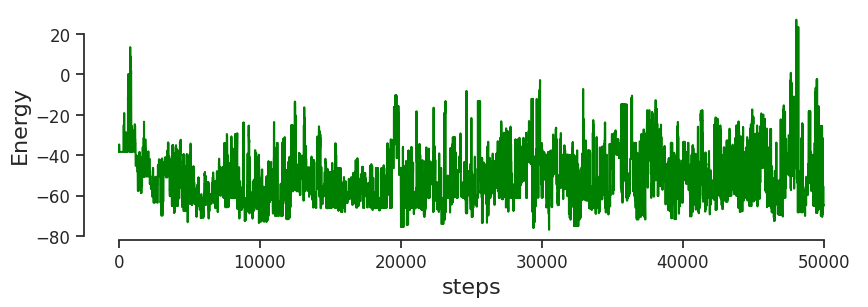

In [132]:
Nini = 00
plt.figure(figsize=(10, 3))
                                                          
#plt.title(str(activation_function) + ', ' + 'n=' + str(n) +', r=' + str(realization))
plt.plot(trace.t[trace.t > Nini], trace.H[trace.t > Nini],color='green')
plt.xlabel('steps',fontsize=size_axis);plt.ylabel('Energy',fontsize=size_axis)
plt.xticks(fontsize=size_ticks)
plt.yticks(fontsize=size_ticks)
#plt.scatter(minrow['t'], minH,color='r')
sns.despine(trim=True)

namefig='Energy_' + activation_function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

for ext in extensions:
        plt.savefig(output_path + namefig + ext,dpi=300)

 
plt.show()

,x1,y,rep,noise,y_noise,ymodel,ybms
59,1.00,0.100895,7.0,0.002004,0.102899,0.271664,0.091738
60,1.05,0.100688,7.0,-0.038121,0.062567,0.283632,0.090156
61,1.10,0.100734,7.0,-0.069537,0.031197,0.295042,0.088844
62,1.15,0.101028,7.0,0.008214,0.109242,0.305879,0.087778
63,1.20,0.101568,7.0,-0.009986,0.091581,0.316138,0.086939
64,1.25,0.102350,7.0,0.037608,0.139958,0.325827,0.086308
65,1.30,0.103376,7.0,-0.003606,0.099771,0.334963,0.085869
66,1.35,0.104647,7.0,-0.007616,0.097031,0.343564,0.085609
67,1.40,0.106166,7.0,0.041067,0.147233,0.351657,0.085514
68,1.45,0.107939,7.0,0.007360,0.115299,0.359266,0.085572


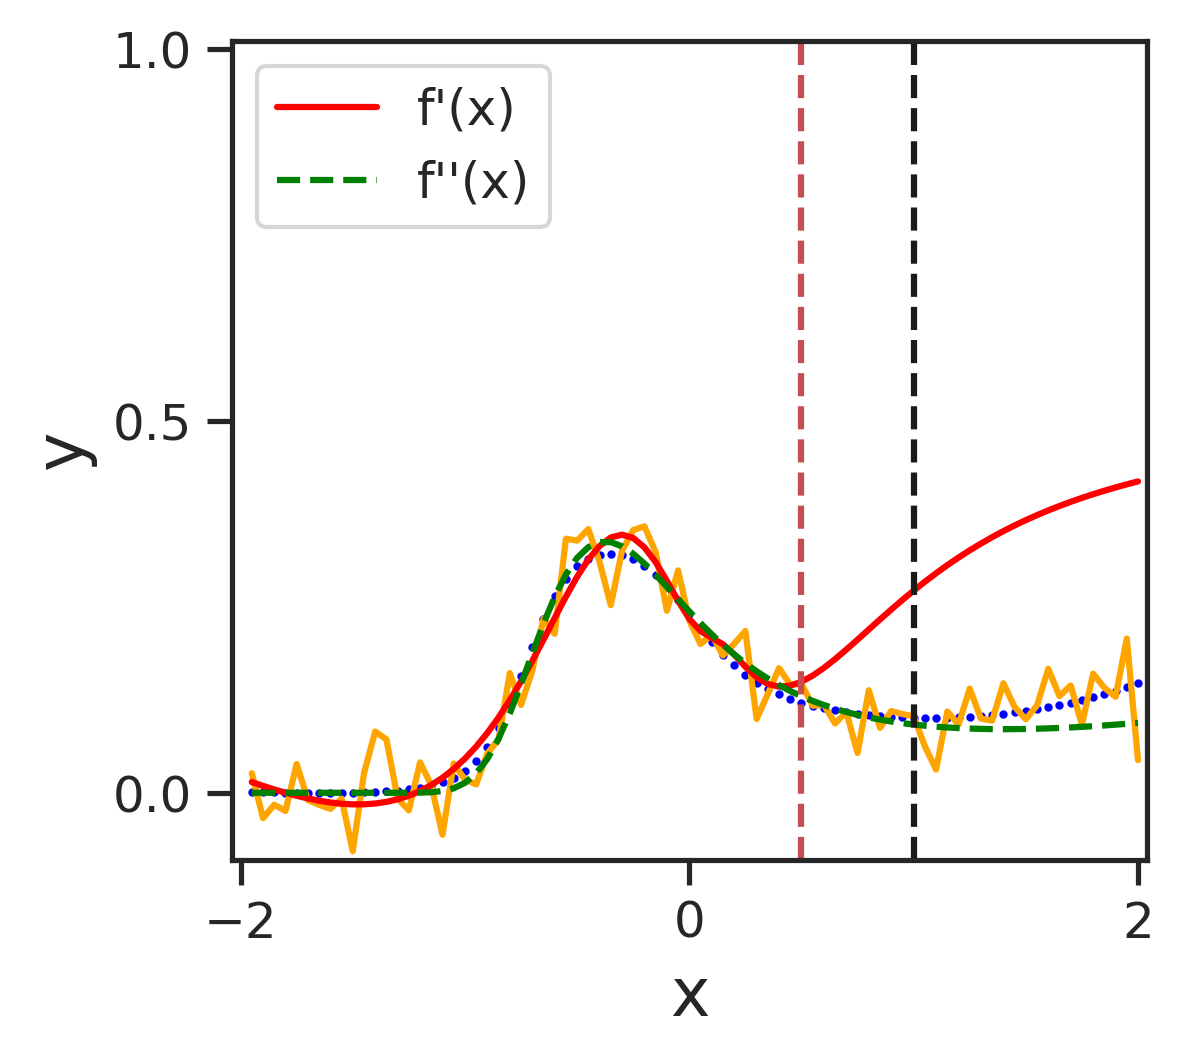

In [131]:
#Plot
train_size_ann=50
validation_border=dn.loc[train_size_ann-1]['x1']
train_border=dn.loc[train_size-1]['x1']

dplot = deepcopy(dn)
dplot['ybms'] = t.predict(x)
display(dplot.loc[train_size-1:])

rmse_nn_train=root_mean_squared_error(dplot.loc[:train_size-1]['ymodel'],dplot.loc[:train_size -1]['y'])
rmse_nn_test=root_mean_squared_error(dplot.loc[train_size-1:]['ymodel'],dplot.loc[train_size -1:]['y'])
rmse_mdl_train=root_mean_squared_error(dplot.loc[:train_size-1]['ybms'],dn.loc[:train_size-1]['y'])
rmse_mdl_test =root_mean_squared_error(dplot.loc[train_size-1:]['ybms'],dn.loc[train_size-1:]['y'])

#Define figure size in cm                                                                                                                                    
fig=figure(figsize=(width,height), dpi=300)                                                        

#plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='ann.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_nn_train, rmse_nn_test)) 
#plt.plot(dplot.x1, dplot.ybms, color='green', linestyle='--',label='mdl.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_mdl_train, rmse_mdl_test)) 

plt.plot(dn['x1'], dn['y'],'.', markersize=2, color='blue') 
plt.plot(dn['x1'], dn['y_noise'],linewidth=line_w, markersize=2, color='orange')                                                                            
plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label="f'(x)") 
plt.plot(dplot.x1, dplot.ybms, color='green', linestyle='--',label="f''(x)")
plt.axvline(x=validation_border,linestyle='--',linewidth=line_w, color='r')
plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')

#plt.title('$%s$' % t.latex(),fontsize=size_title)
#plt.title('n=%d, r=%d : $%s$' % (n, realization, t.latex()),fontsize=size_title)
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(xtick_labels, fontsize=size_ticks)
plt.yticks(ytick_labels, fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

plt.xlim(xmin,xmax);plt.ylim(ymin,ymax)  

Name_figure='Prediction_' + activation_function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)
    
for ext in extensions:
        plt.savefig('../results/tutorial/' + Name_figure + ext,dpi=300)

plt.show()

In [130]:
#Plot ANN results
train_size_ann=50
validation_border=dn.loc[train_size_ann-1]['x1']

train_border=dn.loc[train_size-1]['x1']

dplot = deepcopy(dn)
dplot['ybms'] = t.predict(x)
display(dplot.loc[train_size-1:])

rmse_nn_train=root_mean_squared_error(dplot.loc[:train_size-1]['ymodel'],dplot.loc[:train_size -1]['y'])
rmse_nn_test=root_mean_squared_error(dplot.loc[train_size-1:]['ymodel'],dplot.loc[train_size -1:]['y'])

#Define figure size in cm                                                                                                                                    
fig=figure(figsize=(width,height), dpi=300)                                                        

plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='ann.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_nn_train, rmse_nn_test))
plt.plot(dn['x1'], dn['y'],'.', markersize=2, color='blue',label='observed data') 
plt.plot(dn['x1'], dn['y_noise'],linewidth=line_w, markersize=2, color='orange',label=r'$\sigma$=' + str(sigma) ) 
                                                                                

plt.axvline(x=validation_border,linestyle='--',linewidth=line_w, color='r')
plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')

#plt.title('$%s$' % t.latex(),fontsize=size_title)
#plt.title('n=%d, r=%d : $%s$' % (n, realization, t.latex()),fontsize=size_title)
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y'',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

#plt.xlim(-4.5,4.5);plt.ylim(-1.1,1.5) 
plt.xlim(xmin,xmax);plt.ylim(ymin,ymax)  

namefig='Prediction_nns' + activation_function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

    
for ext in Extensions:
        plt.savefig(output_path + namefig +ext,dpi=300)

plt.show()

SyntaxError: unterminated string literal (detected at line 27) (240229642.py, line 27)

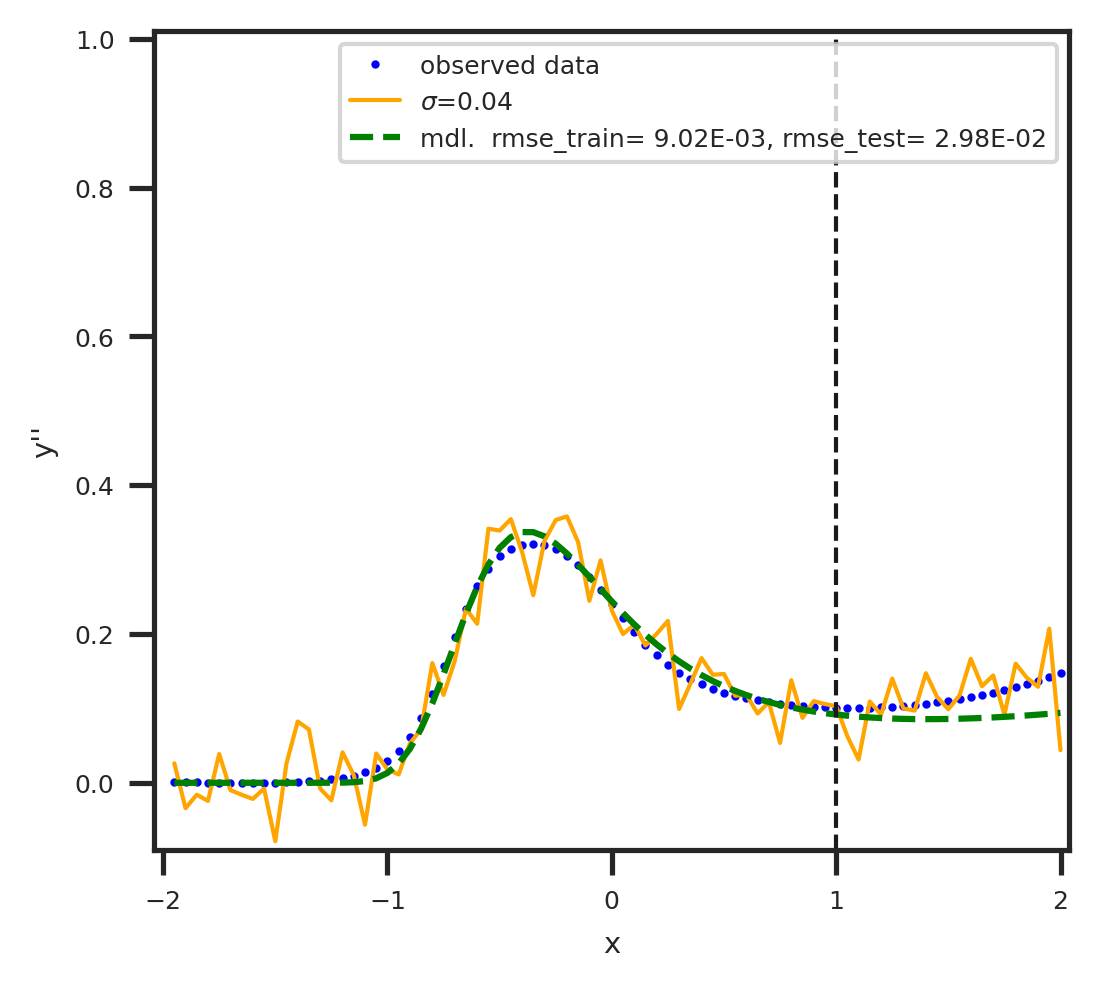

In [90]:
rmse_mdl_train=root_mean_squared_error(dplot.loc[:train_size-1]['ybms'],dn.loc[:train_size-1]['y'])
rmse_mdl_test =root_mean_squared_error(dplot.loc[train_size-1:]['ybms'],dn.loc[train_size-1:]['y'])

#Define figure size in cm                                                                                                                                   
fig=figure(figsize=(width,height), dpi=300) 

plt.plot(dn['x1'], dn['y'],'.', markersize=2, color='blue',label='observed data') 
plt.plot(dn['x1'], dn['y_noise'],linewidth=line_w, markersize=2, color='orange',label=r'$\sigma$=' + str(sigma) ) 
plt.plot(dplot.x1, dplot.ybms, color='green', linestyle='--',label='mdl.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_mdl_train, rmse_mdl_test))
plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')

plt.xlabel('x',fontsize=size_axis);plt.ylabel("y''",fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

plt.xlim(xmin,xmax);plt.ylim(ymin,ymax)  

namefig='Prediction_mdl' + activation_function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)

plt.show()


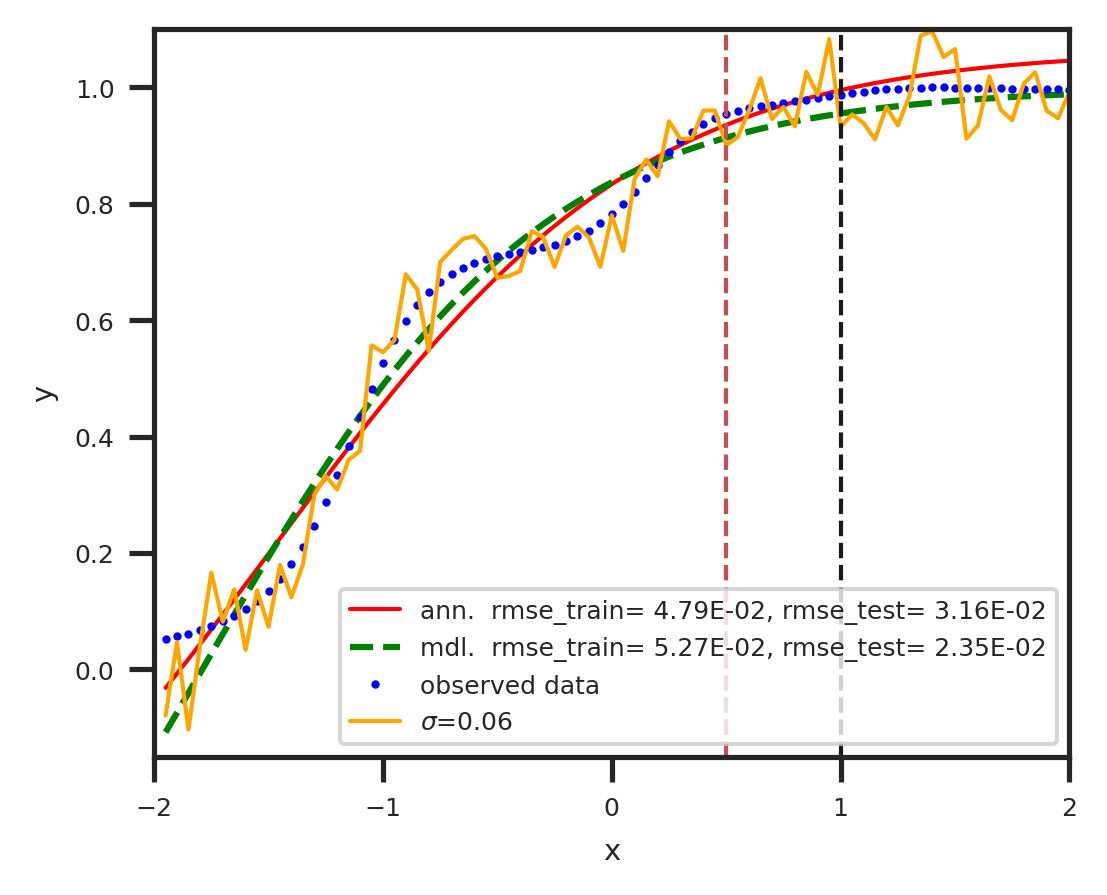

In [36]:
#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 10*cm; height=8*cm
Extensions=['.png', '.pdf']
#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          
fig=figure(figsize=(width,height), dpi=300)                                                        

plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='ann.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_nn_train, rmse_nn_test)) 
plt.plot(dplot.x1, dplot.ybms, color='green', linestyle='--',label='mdl.  rmse_train= %.2E, rmse_test= %.2E' % ( rmse_mdl_train, rmse_mdl_test)) 
plt.plot(dn['x1'], dn['y'],'.', markersize=2, color='blue',label='observed data') 
plt.plot(dn['x1'], dn['y_noise'],linewidth=line_w, markersize=2, color='orange',label=r'$\sigma$=' + str(sigma) )                                                                            

plt.axvline(x=validation_border,linestyle='--',linewidth=line_w, color='r')
plt.axvline(x=train_border,linestyle='--',linewidth=line_w, color='k')

plt.title('$%s$' % t.latex(),fontsize=size_title)
plt.title('n=%d, r=%d : $%s$' % (n, realization, t.latex()),fontsize=size_title)
plt.xlabel('x',fontsize=size_axis);plt.ylabel('y',fontsize=size_axis)
plt.xticks(fontsize=size_ticks);plt.yticks(fontsize=size_ticks)
plt.legend(loc='best', fontsize=size_ticks)

plt.xlim(-2,2);plt.ylim(-0.15,1.1)  

Name_figure='Prediction_' + activation_function + '_n_' + str(n) + '_sigma_' + str(sigma) + '_r_'  + str(realization) + '_par_' + str(NPAR)
    
for ext in Extensions:
        plt.savefig('../results/' + Name_figure +ext,dpi=300)

plt.show()